# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creamos función de costo

In [20]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

# Creación del modelo

In [21]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(100, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation= custom_activation)
])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 20000)            80000     
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               2000100   
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                        

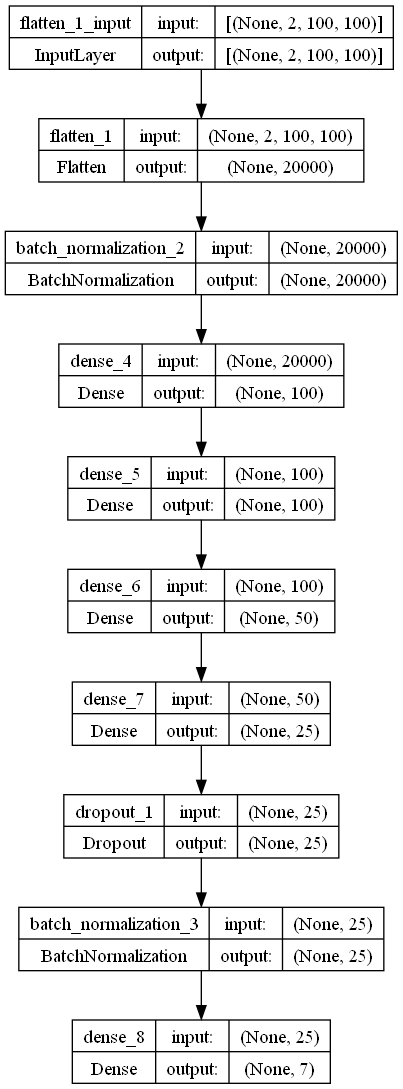

In [25]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [26]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [27]:
model.compile(optimizer= optimizer,
              loss= 'MSE',
              metrics=['mae'])

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 7s 9ms/step - loss: 19.3876 - mae: 2.1721 - val_loss: 12.0294 - val_mae: 1.7572 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 6s 9ms/step - loss: 9.8815 - mae: 1.9521 - val_loss: 7.7267 - val_mae: 1.6578 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 6s 9ms/step - loss: 7.8709 - mae: 1.8129 - val_loss: 5.9529 - val_mae: 1.4152 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 6s 9ms/step - loss: 6.8998 - mae: 1.7052 - val_loss: 5.2673 - val_mae: 1.3436 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 6s 9ms/step - loss: 6.4847 - mae: 1.6812 - val_loss: 4.8755 - val_mae: 1.2913 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 6s 9ms/step - loss: 6.5512 - mae: 1.6866 - val_loss: 5.2824 - val_mae: 1.3190 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 6s 9ms/step - loss: 6.4515 - mae: 1.6686 - val_loss: 4.6278 

700/700 [==============================] - 6s 9ms/step - loss: 4.1151 - mae: 1.5130 - val_loss: 2.7055 - val_mae: 0.9857 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1301 - mae: 1.5163 - val_loss: 2.8036 - val_mae: 1.0517 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1188 - mae: 1.5148 - val_loss: 2.8110 - val_mae: 1.0477 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1863 - mae: 1.5304 - val_loss: 2.7521 - val_mae: 1.0303 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1667 - mae: 1.5239 - val_loss: 2.7683 - val_mae: 1.0329 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1904 - mae: 1.5303 - val_loss: 2.7749 - val_mae: 1.0329 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.1431 - mae: 1.5225 - val_loss: 2.7664 - v

700/700 [==============================] - 6s 9ms/step - loss: 4.0892 - mae: 1.5072 - val_loss: 2.8009 - val_mae: 1.0628 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0712 - mae: 1.4955 - val_loss: 2.7555 - val_mae: 1.0225 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0783 - mae: 1.4997 - val_loss: 2.7681 - val_mae: 1.0555 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0349 - mae: 1.4862 - val_loss: 2.8252 - val_mae: 1.0754 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0762 - mae: 1.5003 - val_loss: 2.7540 - val_mae: 1.0420 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0583 - mae: 1.4957 - val_loss: 2.7790 - val_mae: 1.0630 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 6s 9ms/step - loss: 4.0672 - mae: 1.4973 - val_loss: 2.8525 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9794 - mae: 1.4716 - val_loss: 2.8138 - val_mae: 1.0668 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9781 - mae: 1.4694 - val_loss: 2.7296 - val_mae: 1.0246 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9701 - mae: 1.4681 - val_loss: 2.8134 - val_mae: 1.0754 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9422 - mae: 1.4579 - val_loss: 2.7878 - val_mae: 1.0667 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9516 - mae: 1.4637 - val_loss: 2.7635 - val_mae: 1.0523 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9768 - mae: 1.4685 - val_loss: 2.7872 - val_mae: 1.0721 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9871 - mae: 1.4677 - val_loss: 2.7152 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9092 - mae: 1.4525 - val_loss: 2.7582 - val_mae: 1.0671 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8939 - mae: 1.4498 - val_loss: 2.8035 - val_mae: 1.0524 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9452 - mae: 1.4600 - val_loss: 2.7502 - val_mae: 1.0346 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9347 - mae: 1.4561 - val_loss: 2.7504 - val_mae: 1.0465 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9276 - mae: 1.4591 - val_loss: 2.7790 - val_mae: 1.0624 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9214 - mae: 1.4574 - val_loss: 2.8206 - val_mae: 1.0951 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9191 - mae: 1.4543 - val_loss: 2.6817 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9078 - mae: 1.4546 - val_loss: 2.8894 - val_mae: 1.1269 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9285 - mae: 1.4564 - val_loss: 2.7783 - val_mae: 1.0548 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8946 - mae: 1.4471 - val_loss: 2.6412 - val_mae: 0.9909 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8966 - mae: 1.4499 - val_loss: 2.7057 - val_mae: 1.0159 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9466 - mae: 1.4597 - val_loss: 2.7159 - val_mae: 1.0339 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9466 - mae: 1.4626 - val_loss: 2.6912 - val_mae: 1.0168 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9592 - mae: 1.4653 - val_loss: 2.9287 - v

700/700 [==============================] - 6s 9ms/step - loss: 3.9602 - mae: 1.4647 - val_loss: 2.8096 - val_mae: 1.0754 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8905 - mae: 1.4439 - val_loss: 2.8574 - val_mae: 1.0871 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9328 - mae: 1.4563 - val_loss: 2.7569 - val_mae: 1.0471 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9304 - mae: 1.4569 - val_loss: 2.8302 - val_mae: 1.0855 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9109 - mae: 1.4512 - val_loss: 2.6675 - val_mae: 1.0079 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9214 - mae: 1.4522 - val_loss: 2.6958 - val_mae: 1.0113 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9240 - mae: 1.4576 - val_loss: 2.7794 - v

700/700 [==============================] - 7s 9ms/step - loss: 3.8947 - mae: 1.4498 - val_loss: 2.6155 - val_mae: 0.9899 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8947 - mae: 1.4494 - val_loss: 2.6669 - val_mae: 1.0034 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8924 - mae: 1.4558 - val_loss: 2.6166 - val_mae: 0.9863 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8852 - mae: 1.4481 - val_loss: 2.7449 - val_mae: 1.0785 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.9246 - mae: 1.4573 - val_loss: 2.7046 - val_mae: 1.0195 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8962 - mae: 1.4497 - val_loss: 2.7032 - val_mae: 1.0000 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8526 - mae: 1.443

Epoch 494/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8446 - mae: 1.4436 - val_loss: 2.7138 - val_mae: 1.0459 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8393 - mae: 1.4477 - val_loss: 2.6985 - val_mae: 1.0529 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8479 - mae: 1.4454 - val_loss: 2.6862 - val_mae: 1.0375 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8913 - mae: 1.4574 - val_loss: 2.8014 - val_mae: 1.0964 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8832 - mae: 1.4537 - val_loss: 2.7454 - val_mae: 1.0634 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.8375 - mae: 1.4373 - val_loss: 2.6744 - val_mae: 1.0303 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.80

Epoch 601/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7789 - mae: 1.4404 - val_loss: 2.5828 - val_mae: 1.0114 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.8411 - mae: 1.4555 - val_loss: 2.5840 - val_mae: 0.9903 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7585 - mae: 1.4301 - val_loss: 2.5671 - val_mae: 0.9845 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7677 - mae: 1.4359 - val_loss: 2.6135 - val_mae: 1.0373 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7679 - mae: 1.4348 - val_loss: 2.5869 - val_mae: 1.0072 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.7664 - mae: 1.4369 - val_loss: 2.6637 - val_mae: 1.0612 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.77

Epoch 708/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7107 - mae: 1.4323 - val_loss: 2.5338 - val_mae: 0.9950 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7229 - mae: 1.4333 - val_loss: 2.5294 - val_mae: 0.9962 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7087 - mae: 1.4341 - val_loss: 2.5384 - val_mae: 0.9928 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7046 - mae: 1.4314 - val_loss: 2.5117 - val_mae: 1.0117 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7254 - mae: 1.4354 - val_loss: 2.4727 - val_mae: 0.9548 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.7038 - mae: 1.4333 - val_loss: 2.5391 - val_mae: 1.0197 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 6s 8ms/step - loss: 3.67

Epoch 815/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6730 - mae: 1.4314 - val_loss: 2.4513 - val_mae: 0.9814 - lr: 3.1690e-04
Epoch 816/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6517 - mae: 1.4286 - val_loss: 2.4430 - val_mae: 0.9770 - lr: 3.1525e-04
Epoch 817/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6092 - mae: 1.4176 - val_loss: 2.3932 - val_mae: 0.9258 - lr: 3.1360e-04
Epoch 818/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6280 - mae: 1.4209 - val_loss: 2.4240 - val_mae: 0.9558 - lr: 3.1195e-04
Epoch 819/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6182 - mae: 1.4186 - val_loss: 2.4615 - val_mae: 0.9963 - lr: 3.1030e-04
Epoch 820/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.6249 - mae: 1.4249 - val_loss: 2.4326 - val_mae: 0.9652 - lr: 3.0865e-04
Epoch 821/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.59

Epoch 922/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5697 - mae: 1.4172 - val_loss: 2.3655 - val_mae: 0.9402 - lr: 1.4035e-04
Epoch 923/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5694 - mae: 1.4183 - val_loss: 2.3428 - val_mae: 0.9386 - lr: 1.3870e-04
Epoch 924/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5737 - mae: 1.4226 - val_loss: 2.3326 - val_mae: 0.9234 - lr: 1.3705e-04
Epoch 925/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5690 - mae: 1.4183 - val_loss: 2.3513 - val_mae: 0.9320 - lr: 1.3540e-04
Epoch 926/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5743 - mae: 1.4179 - val_loss: 2.3528 - val_mae: 0.9475 - lr: 1.3375e-04
Epoch 927/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.5727 - mae: 1.4176 - val_loss: 2.3361 - val_mae: 0.9259 - lr: 1.3210e-04
Epoch 928/1000
700/700 [==============================] - 6s 9ms/step - loss: 3.54

# Analizamos accuracy y loss

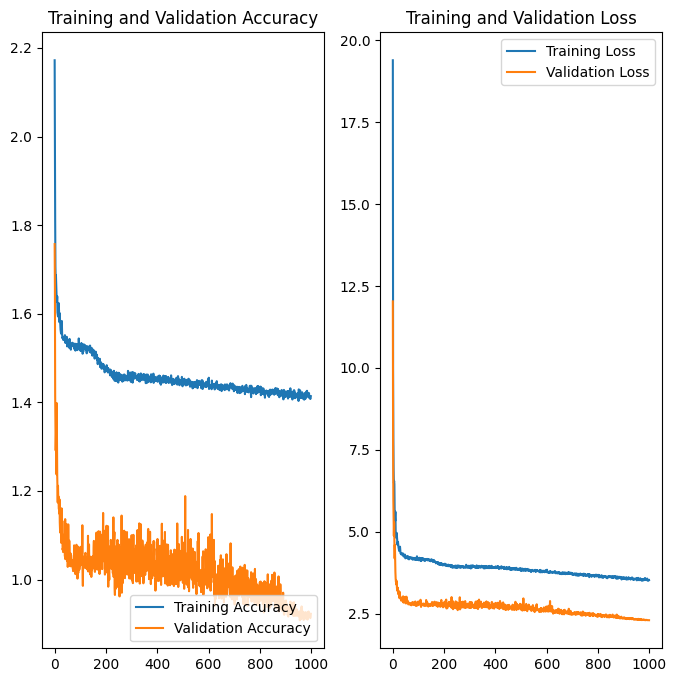

In [30]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(val_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluamos el modelo

In [31]:
test_loss, test_acc = model.evaluate(campvecval,coefcampvecval)

32/32 [==============================] - 0s 4ms/step - loss: 2.3004 - mae: 0.9227


In [32]:
predictions = model.predict(campvecval)

32/32 [==============================] - -1s 3ms/step


In [33]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvecval, predictions)

# Calcula la desviación estándar del error
error = coefcampvecval - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.9226761648898412, Desviación estándar del error: 1.5034250099480853, Error absoluto máximo: 5.328569412231445


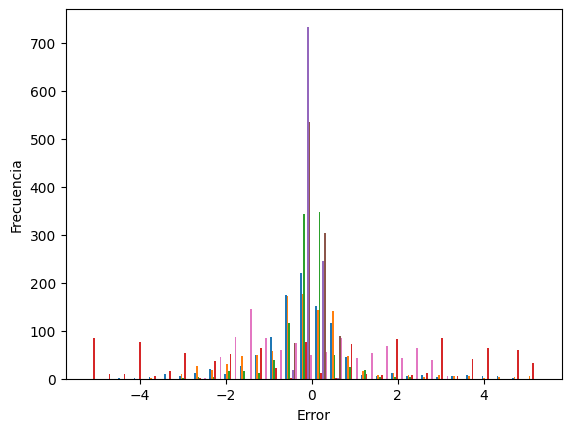

In [34]:
import matplotlib.pyplot as plt

plt.hist(error, bins=30)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

In [35]:
from sklearn.metrics import r2_score

r2 = r2_score(coefcampvecval, predictions)
r2

0.6957455035713941

In [36]:
error_percentile_90 = np.percentile(np.abs(error), 90)
error_percentile_90

2.6294700384140017

# Guardamos los datos de Accuracy y Loss

In [37]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historycampvec100funcioncosto.csv', index = False)

# Guardamos el modelo

In [38]:
path_to_save = '../../../Modelos/Modelos 100,200'

In [39]:
model.save(path_to_save + '/campovectorial100funcioncosto.h5')

# Importamos el modelo

In [1]:
def custom_loss(y_true, y_pred):
    campvec = []
    # constantes
    a1 = tf.cast(y_true[:, 0], tf.float64)
    #tf.print(a1)
    a1 = tf.reshape(a1, shape=(-1, 1, 1))

    a2 = tf.cast(y_true[:, 1], tf.float64)
    a2 = tf.reshape(a2, shape=(-1, 1, 1))
    
    b1 = tf.cast(y_true[:, 2], tf.float64)
    b1 = tf.reshape(b1,shape = (-1,1,1))
    
    b2 = tf.cast(y_true[:, 3], tf.float64)
    b2 = tf.reshape(b2,shape = (-1,1,1))

    d1 = tf.cast(y_true[:, 4], tf.float64)
    d1 = tf.reshape(d1, shape=(-1, 1, 1))

    d2 = tf.cast(y_true[:, 5], tf.float64)
    d2 = tf.reshape(d2, shape=(-1, 1, 1))

    n = tf.cast(y_true[:, 6], tf.float64)
    n = tf.reshape(n, shape=(-1, 1, 1))

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        X = tf.cast(X, tf.float64)
        X = tf.reshape(X, shape=(1, 100,100))
        Y = y[1]
        Y = tf.cast(Y, tf.float64)
        Y = tf.reshape(Y, shape=(1, 100,100))
        
        # definimos cada ODE
        dX_dt = tf.divide(a1,(1 + tf.math.pow(Y, n)+1e-5)) - tf.multiply(d1,X) + b1
        dY_dt = tf.divide(a2,(1 + tf.math.pow(X, n)+1e-7)) - tf.multiply(d2,Y) + b2
        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 20
    y_range_neg = 0
    y_range_pos = 20
    y1 = tf.linspace(x_range_neg, x_range_pos, 100)
    y2 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y1, Y2 = tf.meshgrid(y1, y2)
    t = 0
    u, v = tf.zeros(Y1.shape), tf.zeros(Y2.shape)
    u, v = f(t, [Y1, Y2])
    #M = tf.sqrt(tf.square(u) + tf.square(v))
    #u /= M
    #v /= M
# ----------------------------------------------------------------------------
    campvec2 = []
    # constantes
    a12 = tf.cast(y_pred[:, 0], tf.float64)
    a12 = tf.reshape(a12, shape=(-1, 1, 1))

    a22 = tf.cast(y_pred[:, 1], tf.float64)
    a22 = tf.reshape(a22, shape=(-1, 1, 1))
    
    b12 = tf.cast(y_pred[:, 2], tf.float64)
    b12 = tf.reshape(b12,shape = (-1,1,1))
    
    b22 = tf.cast(y_pred[:, 3], tf.float64)
    b22 = tf.reshape(b22,shape = (-1,1,1))

    d12 = tf.cast(y_pred[:, 4], tf.float64)
    d12 = tf.reshape(d12, shape=(-1, 1, 1))

    d22 = tf.cast(y_pred[:, 5], tf.float64)
    d22 = tf.reshape(d22, shape=(-1, 1, 1))

    n2 = tf.cast(y_pred[:, 6], tf.float64)
    n2 = tf.reshape(n2, shape=(-1, 1, 1))
    
    def f2(t2, ye2):

        # asignar a cada ODE a un elemento de vector
        X2 = ye2[0]
        X2 = tf.cast(X2, tf.float64)
        X2 = tf.reshape(X2, shape=(1, 100,100))
        Y2 = ye2[1]
        Y2 = tf.cast(Y2, tf.float64)
        Y2 = tf.reshape(Y2, shape=(1, 100,100))

        # definimos cada ODE
        dX2_dt = tf.divide(a12,(1 + tf.math.pow(Y2, n2)+1e-8)) - tf.multiply(d12,X2) + b12
        dY2_dt = tf.divide(a22,(1 + tf.math.pow(X2, n2)+1e-8)) - tf.multiply(d22,Y2) + b22
        return [dX2_dt, dY2_dt]

    y12 = tf.linspace(x_range_neg, x_range_pos, 100)
    y22 = tf.linspace(y_range_neg, y_range_pos, 100)
    Y12, Y22 = tf.meshgrid(y12, y22)
    u2, v2 = tf.zeros(Y12.shape), tf.zeros(Y22.shape)
    u2, v2 = f2(t, [Y12, Y22])
    #M2 = tf.sqrt(tf.square(u2) + tf.square(v2))
    #u2 /= M2
    #v2 /= M2
    campvecx = tf.abs(tf.subtract(u,u2))
    campvecy = tf.abs(tf.subtract(v,v2))
    campvec_magnitude = tf.add(campvecx,campvecy)
    loss = tf.reduce_mean(campvec_magnitude)
    #tf.print(y_pred)
    return loss

In [2]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [3]:
import keras
import tensorflow as tf
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100funcioncosto.h5', 
                                    custom_objects={'custom_activation': custom_activation, 'custom_loss': custom_loss})

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [4]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)
coef = np.array(coef)


--------------------------------------------
[4, 6, 8, 0, 0, 1, 0]


In [7]:
campvecnone = campvec[None, :]


(1, 2, 100, 100)

## Predecimos con los datos nuevos

In [8]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(np.shape(new_predictions))

1/1 [==============================] - 0s 109ms/step
(1, 7)


##  Encontramos puntos de equilibro datos reales

In [64]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.0689745596904, 4.200049177755501)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

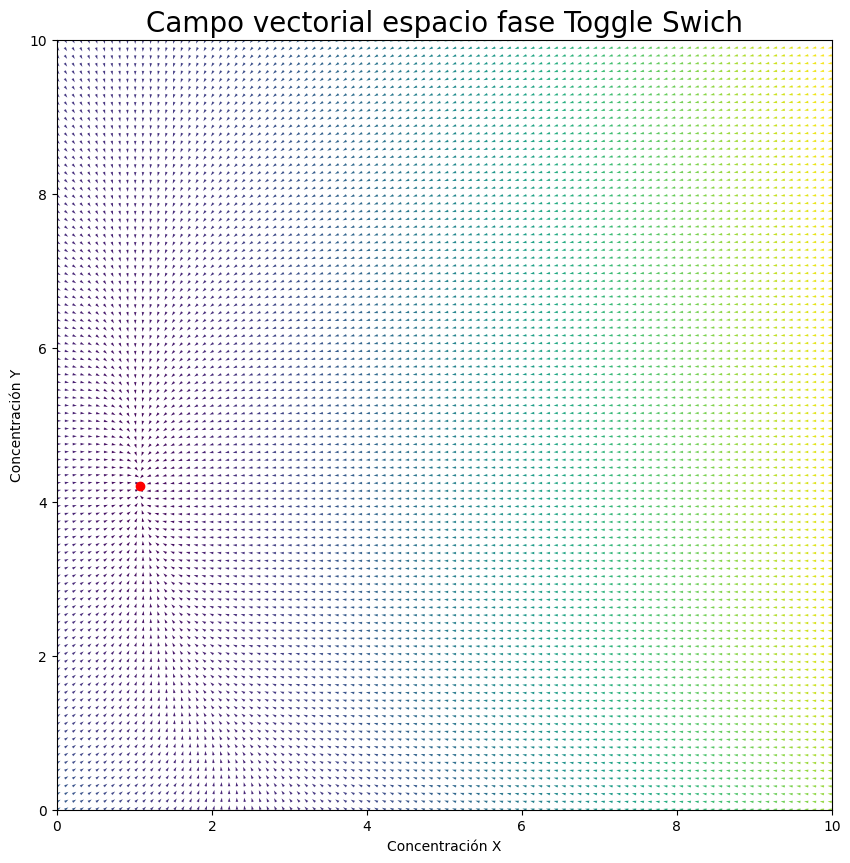

In [65]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [66]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.0167503142386682, 4.231315844955785)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

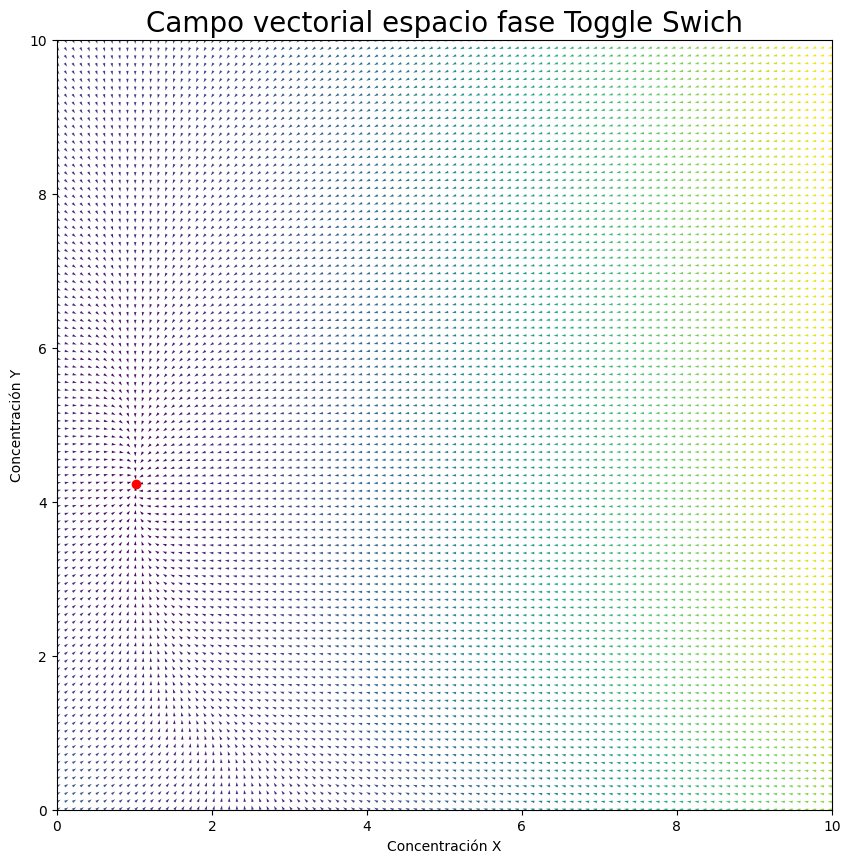

In [67]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

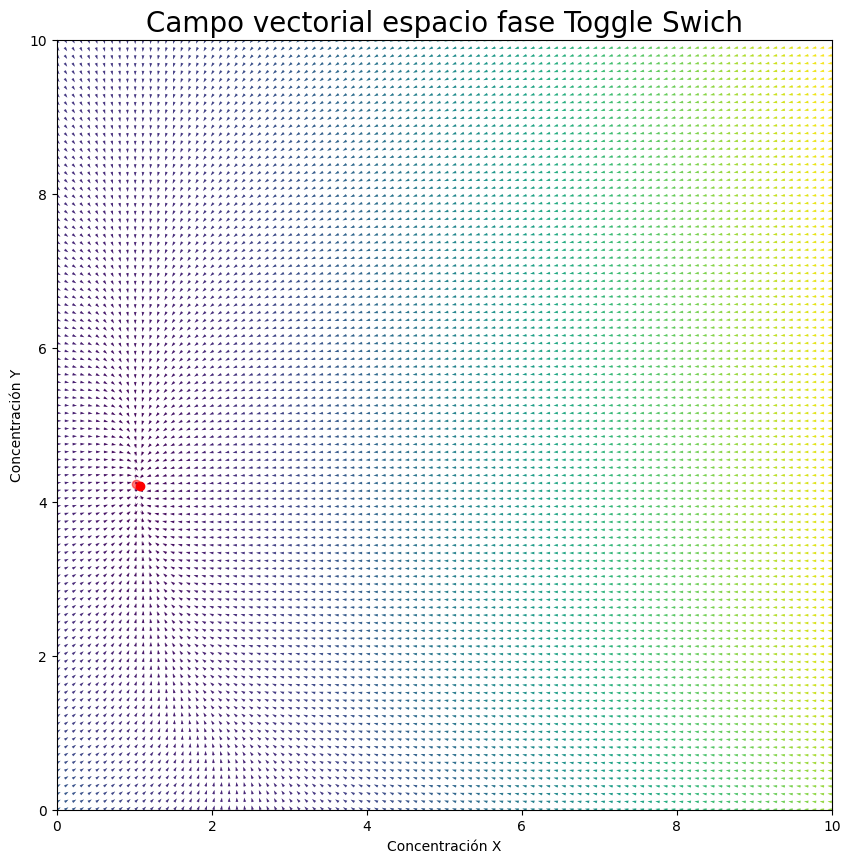

In [68]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

26.268468178652302


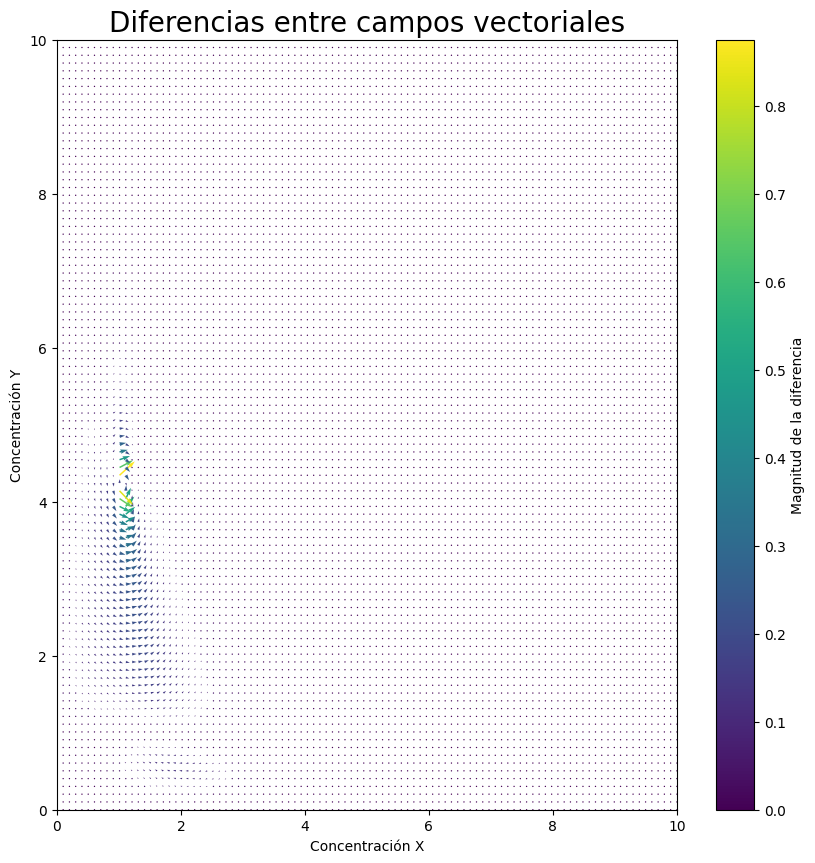

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7
u_diff2 = u_diff + epsilon
v_diff2 = v_diff + epsilon

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.
scale = 70

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

In [70]:
M_diff.mean()

0.01493726761218677

## Errores realativos

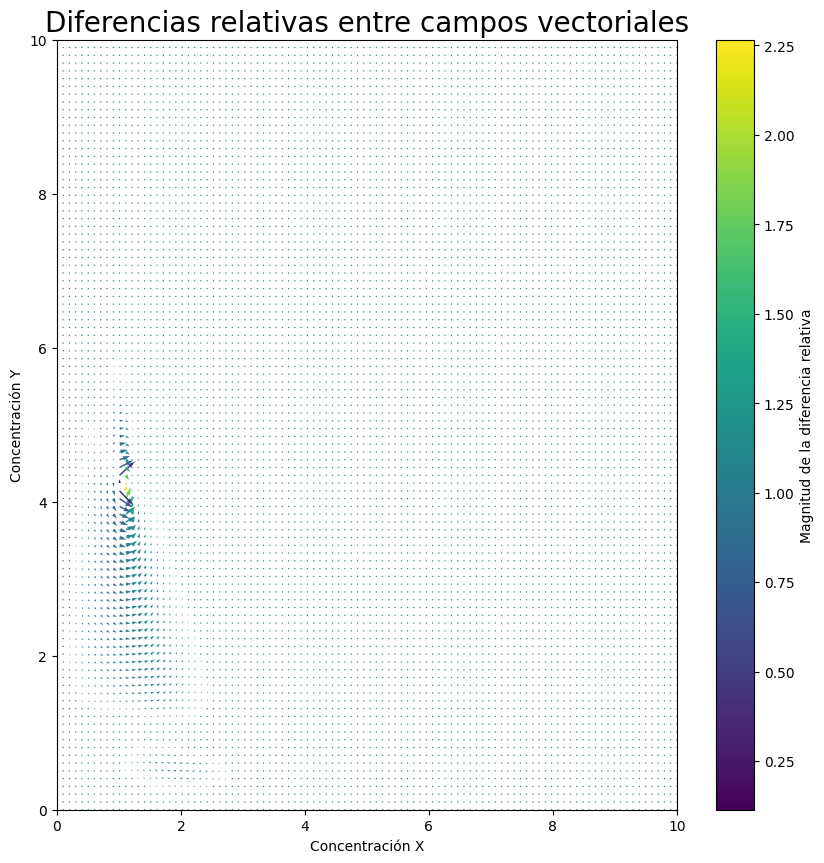

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [72]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 2.266057012290558
El valor de u1 en el error relativo máximo es: -0.2819458262991468
El valor de u1pred en el error relativo máximo es: -0.6528310229607017
El valor de v1 en el error relativo máximo es: 0.05971315363580665
El valor de v1pred en el error relativo máximo es: -0.017935281093174993


In [73]:
np.sqrt(u1pred[max_coords]**2+v1pred[max_coords]**2)/np.sqrt(u1[max_coords]**2+v1[max_coords]**2)

2.266057798570499

In [74]:
M_diff_rel[max_coords]== 0
M_diff_rel.max()

2.266057012290558